# Deconvolution of histocytometry images

I'm running this with Mesmer_pypi conda environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
import os
from pathlib import Path
import tifffile
import re

## Example Richardson-Lucy Deconvolution 

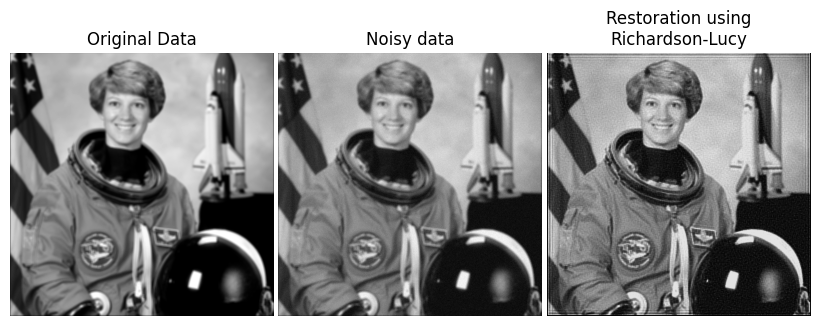

In [2]:
rng = np.random.default_rng()
astro = color.rgb2gray(data.astronaut())

psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, num_iter=30)

## Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

## Histocytometry data

In [9]:
## Functions 
def histocytometry_deconv(raw_image_dir, image_name, psf_dir_path, num_iter):
    image_dirs = [os.path.join(raw_image_dir, image_dir, image_name) for image_dir in os.listdir(raw_image_dir) if re.search("20x|40x", image_dir)] 
    psf_imgs   = [os.path.join(psf_dir_path, psf_img) for psf_img in os.listdir(psf_dir_path)]

    for image_path in image_dirs: 
        img = tifffile.imread(image_path)
        deconvolved_channels = [None] * np.shape(img)[0] # Assuming ch x m x n

        resolution= "20x"
        if re.search("40x", image_path):
            resolution = "40x"  
        for z in range(0, 64):
            ## This is the number of dimensions in the psf_image

            ## Run deconvolution on each channel in the image
            for i in range(len(deconvolved_channels)):
                psf_path = [psf_img for psf_img in psf_imgs if re.search("ch" + str(i+1) + ".tif", psf_img) and re.search(resolution, psf_img)]
                assert len(psf_path) == 1

                psf_img = tifffile.imread(psf_path)
                psf_img = psf_img[z,...]
                    ## Selecting Z-stack to use for 2D deconvolution 
                    ## Assumes Z, x, y dimensions
                deconvolved_channels[i] = restoration.richardson_lucy(img[i,...], psf= psf_img, num_iter= num_iter)
                    
            deconvolved_img = np.stack(deconvolved_channels)
            tifffile.imwrite(re.sub(image_name, "RL_deconvolved_image_" + str(z) + ".tif", image_path), deconvolved_img)
            print("Done with Z: " + z + "!")
        print("Done with one image!")
    
    return None

In [10]:
histocytometry_deconv(raw_image_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images", 
                      image_name    = "image.tif", 
                      psf_dir_path  = "/stor/work/Ehrlich/Users/John/projects/misc/histocytometry/PSF_images", 
                      num_iter      = 10)

## These PSF images are not correct.
    ## I'm going to loop through all of the 3D PSFs for one image and see how that looks. 
    ## If this fails, I could either think about calculating the 2D PSF in python. (The FIJI plugin failed for 2D PSFs for some reason.)
    ## I could also skip deconvolution and just do Aydin denoising.
    ## Does Aydin do deconvolution on a 2D image? 

## It fails for two images. This 3D PSF does not generalize to the 2D image. 

## Blind RL deconvolution is the answer? 
    ## The other option is a Butterworth filter. 


Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one Z!
Done with one 

KeyboardInterrupt: 

## Example poor deconvolution 
40x_Cortex_DAPI_CD63_CD11c_XCR1

In [2]:
example_deconv = tifffile.imread("/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/40x_Cortex_DAPI_CD63_CD11c_XCR1/RL_deconvolved_image_23.tif")

In [3]:
np.shape(example_deconv)

(4, 2048, 2048)

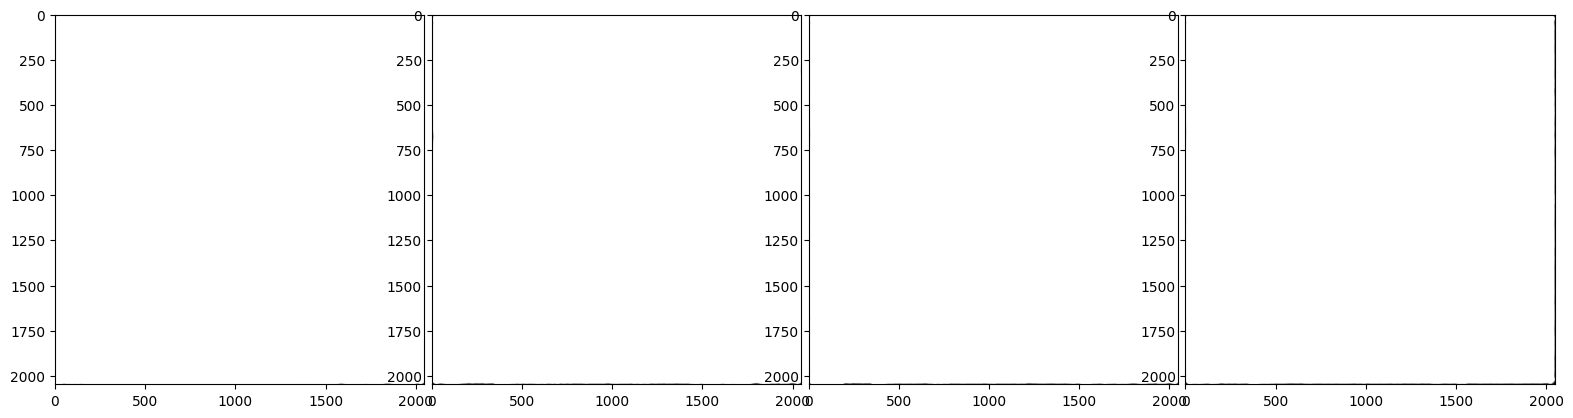

In [8]:
## Plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
# plt.gray()

ax[0].imshow(example_deconv[0,...])
ax[1].imshow(example_deconv[1,...])
ax[2].imshow(example_deconv[2,...])
ax[3].imshow(example_deconv[3,...])



fig.subplots_adjust(wspace= 0.02, hspace= 0.2, top= 0.9, bottom= 0.05, left= 0, right= 1)
plt.show()

TypeError: Invalid shape (4, 2048, 2048) for image data

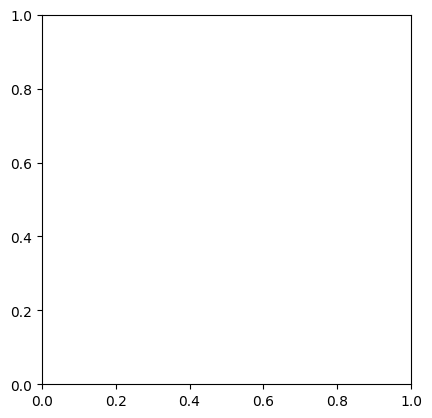

In [11]:
f = plt.figure()
plt.imshow(example_deconv)
plt.show()